In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/TSMCLSTM/uploaded.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Close,TWD,TAIEX,SOX,TAIBOR,DIJA
0,2009-01-05,46.02,33.00,4698.31,223.29,1.02,8952.89
1,2009-01-06,45.37,33.10,4727.26,234.56,1.02,9015.10
2,2009-01-07,44.33,33.03,4789.84,223.12,1.02,8769.70
3,2009-01-08,41.34,33.10,4535.79,222.54,0.62,8742.46
4,2009-01-09,40.80,33.20,4502.74,215.28,0.62,8599.18


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.029214,0.670641,0.065003,0.027305,1.000000,0.118623
1,0.026346,0.685544,0.069132,0.036271,1.000000,0.121691
2,0.021756,0.675112,0.078059,0.027169,1.000000,0.109591
3,0.008561,0.685544,0.041820,0.026708,0.534884,0.108248
4,0.006178,0.700447,0.037106,0.020932,0.534884,0.101183


In [0]:
timestamp = 5
epoch = 100
future_day = 50

In [0]:
def embed_seq(
    inputs, vocab_size = None, embed_dim = None, zero_pad = False, scale = False
):
    lookup_table = tf.get_variable(
        'lookup_table', dtype = tf.float32, shape = [vocab_size, embed_dim]
    )
    if zero_pad:
        lookup_table = tf.concat(
            (tf.zeros([1, embed_dim]), lookup_table[1:, :]), axis = 0
        )
    outputs = tf.nn.embedding_lookup(lookup_table, inputs)
    if scale:
        outputs = outputs * (embed_dim ** 0.5)
    return outputs


def learned_positional_encoding(
    inputs, embed_dim, zero_pad = False, scale = False
):
    T = inputs.get_shape().as_list()[1]
    outputs = tf.range(T)
    outputs = tf.expand_dims(outputs, 0)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])
    return embed_seq(outputs, T, embed_dim, zero_pad = zero_pad, scale = scale)


def layer_norm(inputs, epsilon = 1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims = True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable(
        'gamma', params_shape, tf.float32, tf.ones_initializer()
    )
    beta = tf.get_variable(
        'beta', params_shape, tf.float32, tf.zeros_initializer()
    )
    return gamma * normalized + beta


def pointwise_feedforward(inputs, num_units = [None, None], activation = None):
    outputs = tf.layers.conv1d(
        inputs, num_units[0], kernel_size = 1, activation = activation
    )
    outputs = tf.layers.conv1d(
        outputs, num_units[1], kernel_size = 1, activation = None
    )
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


class Model:
    def __init__(
        self,
        dimension_input,
        dimension_output,
        seq_len,
        learning_rate,
        num_heads = 8,
        attn_windows = range(1, 6),
    ):
        self.size_layer = dimension_input
        self.num_heads = num_heads
        self.seq_len = seq_len
        self.X = tf.placeholder(tf.float32, [None, seq_len, dimension_input])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        feed = self.X
        for i, win_size in enumerate(attn_windows):
            with tf.variable_scope('attn_masked_window_%d' % win_size):
                feed = self.multihead_attn(feed, self.window_mask(win_size))
        feed += learned_positional_encoding(feed, dimension_input)
        with tf.variable_scope('multihead'):
            feed = self.multihead_attn(feed, None)
        with tf.variable_scope('pointwise'):
            feed = pointwise_feedforward(
                feed,
                num_units = [4 * dimension_input, dimension_input],
                activation = tf.nn.relu,
            )
        self.logits = tf.layers.dense(feed, dimension_output)[:, -1]
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        self.correct_pred = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1)
        )
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

    def multihead_attn(self, inputs, masks):
        T_q = T_k = inputs.get_shape().as_list()[1]
        Q_K_V = tf.layers.dense(inputs, 3 * self.size_layer, tf.nn.relu)
        Q, K, V = tf.split(Q_K_V, 3, -1)
        Q_ = tf.concat(tf.split(Q, self.num_heads, axis = 2), axis = 0)
        K_ = tf.concat(tf.split(K, self.num_heads, axis = 2), axis = 0)
        V_ = tf.concat(tf.split(V, self.num_heads, axis = 2), axis = 0)
        align = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1]))
        align = align / np.sqrt(K_.get_shape().as_list()[-1])
        if masks is not None:
            paddings = tf.fill(tf.shape(align), float('-inf'))
            align = tf.where(tf.equal(masks, 0), paddings, align)
        align = tf.nn.softmax(align)
        outputs = tf.matmul(align, V_)
        outputs = tf.concat(
            tf.split(outputs, self.num_heads, axis = 0), axis = 2
        )
        outputs += inputs
        return layer_norm(outputs)

    def window_mask(self, h_w):
        masks = np.zeros([self.seq_len, self.seq_len])
        for i in range(self.seq_len):
            if i < h_w:
                masks[i, : i + h_w + 1] = 1.0
            elif i > self.seq_len - h_w - 1:
                masks[i, i - h_w :] = 1.0
            else:
                masks[i, i - h_w : i + h_w + 1] = 1.0
        masks = tf.convert_to_tensor(masks)
        return tf.tile(
            tf.expand_dims(masks, 0),
            [tf.shape(self.X)[0] * self.num_heads, 1, 1],
        )

In [7]:
tf.reset_default_graph()
modelnn = Model(
    df_log.shape[1],
    df_log.shape[1],
    timestamp,
    0.01,
    num_heads = df_log.shape[1],
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

W0625 07:41:30.325202 139798800766848 deprecation.py:323] From <ipython-input-6-8eee72aabc9a>:92: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0625 07:41:30.516750 139798800766848 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 07:41:31.111968 139798800766848 deprecation.py:323] From <ipython-input-6-8eee72aabc9a>:101: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0625 07:41:31.918704 1

In [8]:
for i in range(epoch):
    total_loss = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(
            df_log.iloc[k : k + timestamp].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : k + timestamp + 1].values
        _, loss = sess.run(
            [modelnn.optimizer, modelnn.cost],
            feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
        )
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0055510247206522305


In [0]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp

for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 0)
        },
    )
    output_predict[k + 1 : k + timestamp + 1] = out_logits

df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [0]:
for i in range(future_day - 1):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0)
        },
    )
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [0]:
df_log = minmax.inverse_transform(df_log.values)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [0]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

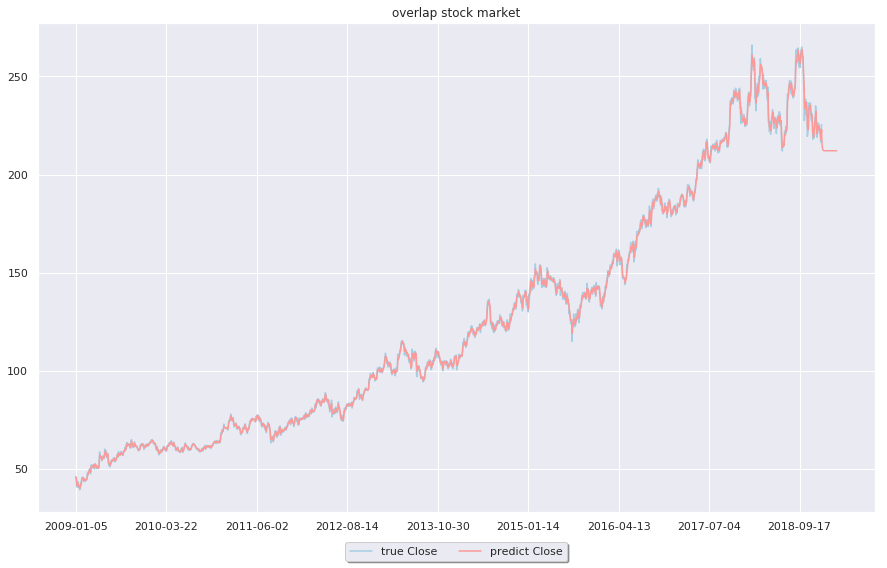

In [22]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Close',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Close',
    color = current_palette[4],
)

box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::300], date_ori[::300])
plt.show()

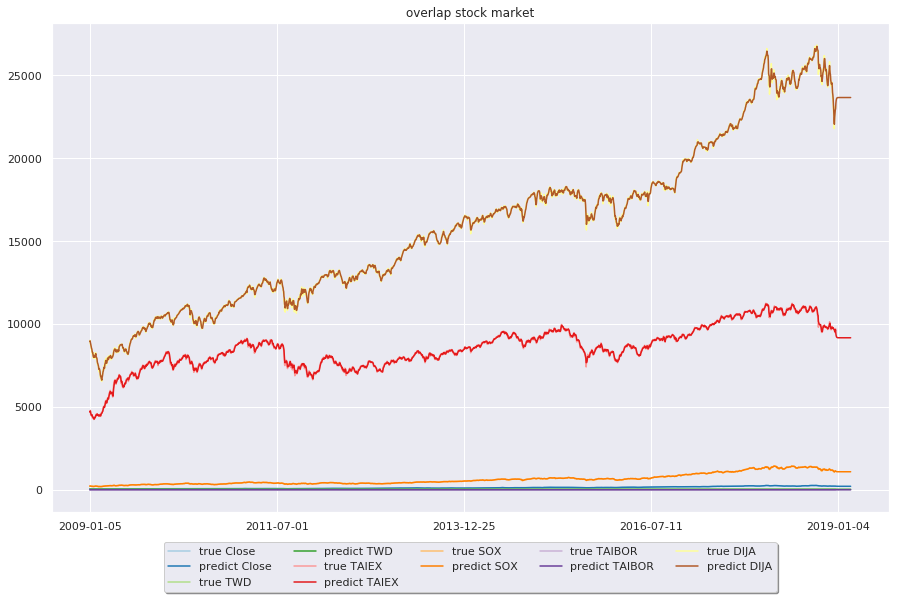

In [13]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Close',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Close',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true TWD',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict TWD',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true TAIEX',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict TAIEX',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true SOX',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict SOX',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true TAIBOR',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict TAIBOR',
    color = current_palette[9],
)
ax.plot(
    x_range_original,
    df.iloc[:, 6],
    label = 'true DIJA',
    color = current_palette[10],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 5], 0.5),
    label = 'predict DIJA',
    color = current_palette[11],
)

box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::620], date_ori[::620])
plt.show()

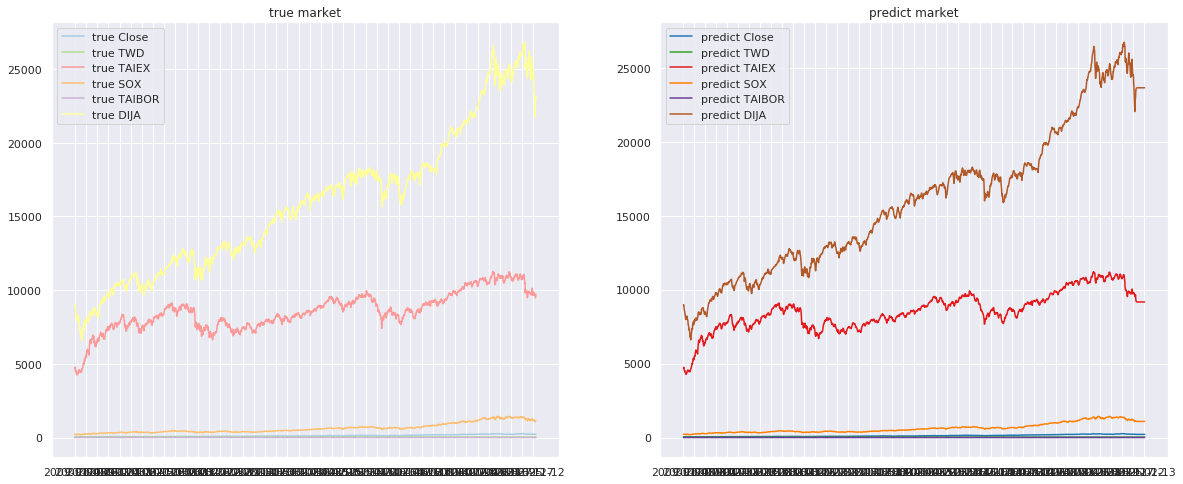

In [14]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Close',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true TWD',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true TAIEX',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true SOX',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true TAIBOR',
    color = current_palette[8],
)
plt.plot(
    x_range_original,
    df.iloc[:, 6],
    label = 'true DIJA',
    color = current_palette[10],
)

plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Close',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict TWD',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict TAIEX',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict SOX',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict TAIBOR',
    color = current_palette[9],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 5], 0.5),
    label = 'predict DIJA',
    color = current_palette[11],
)

plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()